# 1. Decay-chain problem

## 1.1 Problem description

This benchmark is meant to model the migration of radionuclides in the Curium-247 decay chain through a semi-infinite porous column. The diagram below maps the Curium-247 decay chain which contains 6 radionuclides before ending with Actinium-227.

In [2]:
import os
import time

import h5py
import matplotlib.pyplot as plt
import numpy as np
import vtuIO
from IPython.display import Image, display
from matplotlib.pyplot import cm
from scipy import special

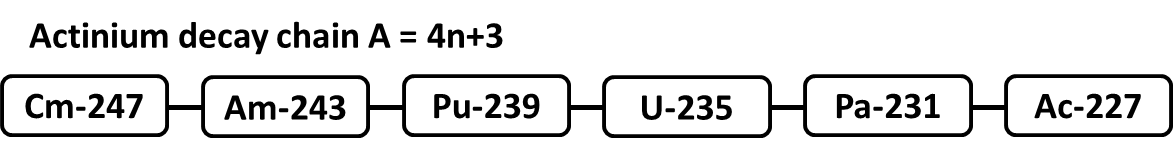

In [3]:
display(Image(filename="chains.png", width=600))

According to the mass conservative law, the diffusive transport of each member of the Curium-247 decay chain can be described by

$$
\frac{\partial \left( \phi c_{i} \right)}{\partial t} = \nabla \cdot \left(\phi \mathrm{D_p} \nabla c_{i} \right) + \phi k_{i-1} c_{i-1} - \phi k_{i} c_{i}, \quad \forall i = 1,2,...,n,
$$

where $c_{i}$ [mol/m$^3$] is the radionuclide concentration, $\phi$ [-] is the porosity, $\mathrm{D_p}$ [m$^2$/s] is the pore diffusion coefficient, and $k_{i}$ [1/s] is the first-order decay constant of a radionuclide, i.e.:

$$
k = \mathrm{ln} 2 \, / \, t_{1/2},
$$

where $t_{1/2}$ [s] is its half life.

## 1.2 Model setups

In the 1-D model, the computational domain is set to be 20 meters long, which is sufficient to ensure that the concentration profile does not reach the right-hand-side boundary during simulation. The simulated time is 100 thousand years. Initially, the entire domain is assumed to be solute free, i.e., $c_{\mathrm{ini}}(x, 0) = 0$ mol/m$^3$. The inlet concentration for all the radionuclides is held at 10$^{-3}$ mol/m$^3$ throughout the simulation, i.e., $c(0, t) = 1$ mol/L. The spatial domain is discretized by linear line elements and the near-inlet grids are refined in order to achieve sufficiently high accuracy. A fixed time step size of one hundred years is used in the simulation. The linearized governing equation system is iteratively solved using the standard Picard iteration method.

The table below summarizes the transport parameters and spatio-temporal discretization parameters used in the simulation.

| Parameter | Value | Unit |
| :-: | :-: | :-: |
| Porosity $\phi$ | 0.12 | - |
| Pore diffusion coefficient $\mathrm{D_p}$ | 1e-11 | m$^2$/s |
| Time step size $\Delta t$ | 1e2 | year |
| Grid size $\Delta x$ | 0.00512 - 1.985 | m|

The following table lists the dataset for the half-life of the radionuclides

| Radionuclide | Half-life [year]| First-order decay constant [1/year] |
| :-: | :-: | :-: |
| Cm-247 | 1.56$\times$10$^{7}$ | 4.44$\times$10$^{-8}$ |
| Am-243 | 7.37$\times$10$^{3}$ | 9.40$\times$10$^{-5}$ |
| Pu-239 | 2.41$\times$10$^{4}$ | 2.88$\times$10$^{-5}$ |
|  U-235 | 7.04$\times$10$^{8}$ | 9.84$\times$10$^{-10}$ |
| Pa-231 | 3.28$\times$10$^{4}$ | 2.11$\times$10$^{-5}$ |
| Ac-227 | 21.773 | 3.18$\times$10$^{-2}$ |

Notes: The half-life dataset is sourced from Report GRS-289.

## 1.3 Results

**Analytical solution**

The analytical solution for the diffusive transport of radionuclides that are degrading sequentially with a series of first-order reactions is given in Sun et al. (1999):

$$
c_{i} = a_{i} - \sum_{j=1}^{i-1} \prod_{l=j}^{i=1} \frac{k_{l}}{k_{l} - k_{i}} c_{j}, \quad \forall i = 1,2,...,n,
$$

Below a python script is presented, through which the concentration profiles of radionuclides in the Curium-247 decay chain are analytically calculated over a period of 10$^5$ years.

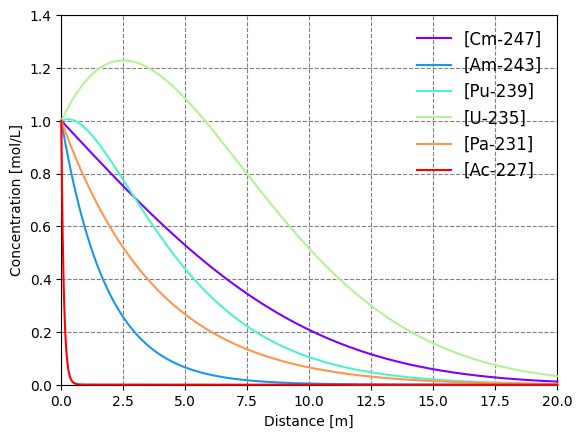

In [4]:
def computeProduct(j, i, k, c_inlet):
    value = 1
    for l in range(j, i):
        value *= k[l] / (k[l] - k[i]) * c_inlet[j]

    return value


def computeInitialAuxiliaryVariable(c_inlet, k):
    a_inlet = np.empty(0)

    for i in range(len(c_inlet)):
        value = c_inlet[i]
        if i > 0:
            for j in range(i):
                value += computeProduct(j, i, k, c_inlet)
        a_inlet = np.append(a_inlet, value)

    return a_inlet


def computeAnalyticalSolution(x, t, c_0, k, v, D):
    t *= 3.1536e7  # unit conversion from year to second

    beta = (v**2 / 4 / D**2 + k / D) ** 0.5
    return (
        c_0
        / 2
        * np.exp(v * x / 2 / D)
        * (
            np.exp(-beta * x)
            * special.erfc((x - (v**2 + 4 * k * D) ** 0.5 * t) / 2 / (D * t) ** 0.5)
            + np.exp(beta * x)
            * special.erfc((x + (v**2 + 4 * k * D) ** 0.5 * t) / 2 / (D * t) ** 0.5)
        )
    )


###Model parameters###
# Diffusion coefficient [m2/s]
D = 1e-11
# Pore water velocity [m/s]
v = 0
# Half life [year]
radionuclides = np.array(
    ["[Cm-247]", "[Am-243]", "[Pu-239]", "[U-235]", "[Pa-231]", "[Ac-227]"]
)
half_lifes = np.array([1.56e7, 7.37e3, 2.41e4, 7.04e8, 3.28e4, 21.773])
# First-order decay constant [1/s]
k = {
    radionuclide: np.log(2) / half_life / 3.1536e7
    for radionuclide, half_life in zip(radionuclides, half_lifes)
}

###Initial and boundary conditions###
c_inlet = np.ones(6)
a_inlet = dict(
    zip(radionuclides, computeInitialAuxiliaryVariable(c_inlet, list(k.values())))
)

###Spatial and temporal discretization###
# Distance [m]
x = np.linspace(0, 20, num=2001)
# Time [year]
t = 1e5

###Analytical solution###
c = {}
a = {}

c["[Cm-247]"] = computeAnalyticalSolution(
    x, t, a_inlet["[Cm-247]"], k["[Cm-247]"], v, D
)

a["[Am-243]"] = computeAnalyticalSolution(
    x, t, a_inlet["[Am-243]"], k["[Am-243]"], v, D
)
c["[Am-243]"] = (
    a["[Am-243]"] - k["[Cm-247]"] / (k["[Cm-247]"] - k["[Am-243]"]) * c["[Cm-247]"]
)

a["[Pu-239]"] = computeAnalyticalSolution(
    x, t, a_inlet["[Pu-239]"], k["[Pu-239]"], v, D
)
c["[Pu-239]"] = (
    a["[Pu-239]"]
    - k["[Cm-247]"]
    / (k["[Cm-247]"] - k["[Pu-239]"])
    * k["[Am-243]"]
    / (k["[Am-243]"] - k["[Pu-239]"])
    * c["[Cm-247]"]
    - k["[Am-243]"] / (k["[Am-243]"] - k["[Pu-239]"]) * c["[Am-243]"]
)

a["[U-235]"] = computeAnalyticalSolution(x, t, a_inlet["[U-235]"], k["[U-235]"], v, D)
c["[U-235]"] = (
    a["[U-235]"]
    - k["[Cm-247]"]
    / (k["[Cm-247]"] - k["[U-235]"])
    * k["[Am-243]"]
    / (k["[Am-243]"] - k["[U-235]"])
    * k["[Pu-239]"]
    / (k["[Pu-239]"] - k["[U-235]"])
    * c["[Cm-247]"]
    - k["[Am-243]"]
    / (k["[Am-243]"] - k["[U-235]"])
    * k["[Pu-239]"]
    / (k["[Pu-239]"] - k["[U-235]"])
    * c["[Am-243]"]
    - k["[Pu-239]"] / (k["[Pu-239]"] - k["[U-235]"]) * c["[Pu-239]"]
)

a["[Pa-231]"] = computeAnalyticalSolution(
    x, t, a_inlet["[Pa-231]"], k["[Pa-231]"], v, D
)
c["[Pa-231]"] = (
    a["[Pa-231]"]
    - k["[Cm-247]"]
    / (k["[Cm-247]"] - k["[Pa-231]"])
    * k["[Am-243]"]
    / (k["[Am-243]"] - k["[Pa-231]"])
    * k["[Pu-239]"]
    / (k["[Pu-239]"] - k["[Pa-231]"])
    * k["[U-235]"]
    / (k["[U-235]"] - k["[Pa-231]"])
    * c["[Cm-247]"]
    - k["[Am-243]"]
    / (k["[Am-243]"] - k["[Pa-231]"])
    * k["[Pu-239]"]
    / (k["[Pu-239]"] - k["[Pa-231]"])
    * k["[U-235]"]
    / (k["[U-235]"] - k["[Pa-231]"])
    * c["[Am-243]"]
    - k["[Pu-239]"]
    / (k["[Pu-239]"] - k["[Pa-231]"])
    * k["[U-235]"]
    / (k["[U-235]"] - k["[Pa-231]"])
    * c["[Pu-239]"]
    - k["[U-235]"] / (k["[U-235]"] - k["[Pa-231]"]) * c["[U-235]"]
)

a["[Ac-227]"] = computeAnalyticalSolution(
    x, t, a_inlet["[Ac-227]"], k["[Ac-227]"], v, D
)
c["[Ac-227]"] = (
    a["[Ac-227]"]
    - k["[Cm-247]"]
    / (k["[Cm-247]"] - k["[Ac-227]"])
    * k["[Am-243]"]
    / (k["[Am-243]"] - k["[Ac-227]"])
    * k["[Pu-239]"]
    / (k["[Pu-239]"] - k["[Ac-227]"])
    * k["[U-235]"]
    / (k["[U-235]"] - k["[Ac-227]"])
    * k["[Pa-231]"]
    / (k["[Pa-231]"] - k["[Ac-227]"])
    * c["[Cm-247]"]
    - k["[Am-243]"]
    / (k["[Am-243]"] - k["[Ac-227]"])
    * k["[Pu-239]"]
    / (k["[Pu-239]"] - k["[Ac-227]"])
    * k["[U-235]"]
    / (k["[U-235]"] - k["[Ac-227]"])
    * k["[Pa-231]"]
    / (k["[Pa-231]"] - k["[Ac-227]"])
    * c["[Am-243]"]
    - k["[Pu-239]"]
    / (k["[Pu-239]"] - k["[Ac-227]"])
    * k["[U-235]"]
    / (k["[U-235]"] - k["[Ac-227]"])
    * k["[Pa-231]"]
    / (k["[Pa-231]"] - k["[Ac-227]"])
    * c["[Pu-239]"]
    - k["[U-235]"]
    / (k["[U-235]"] - k["[Ac-227]"])
    * k["[Pa-231]"]
    / (k["[Pa-231]"] - k["[Ac-227]"])
    * c["[U-235]"]
    - k["[Pa-231]"] / (k["[Pa-231]"] - k["[Ac-227]"]) * c["[Pa-231]"]
)

###Plot figure###
fig, ax = plt.subplots()

ax.set(xlim=(0, 20), ylim=(0, 1.4))
ax.set(xlabel="Distance [m]", ylabel="Concentration [mol/L]")

color_map = cm.rainbow(np.linspace(0, 1, radionuclides.size))

for radionuclide, color in zip(radionuclides, color_map):
    ax.plot(
        x,
        c[radionuclide],
        linestyle="-",
        lw=1.5,
        label=radionuclide,
        c=color,
        zorder=10,
        clip_on=False,
    )

ax.legend(frameon=False, loc="upper right", numpoints=1, fontsize=12, ncol=1)

ax.xaxis.grid(color="gray", linestyle="dashed")
ax.yaxis.grid(color="gray", linestyle="dashed")

**Numerical solution**

Two numerical models are presented here, one based on the global implicit approach (GIA) and the other on the operator splitting approach (OS). The OGS input files of these two models can be found <a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/Parabolic/ComponentTransport/ReactiveTransport/DecayChain">here</a>. Then, the obtained numerical solutions both are plotted against the analytical solution for verification.

In [11]:
###Run two numerical models###
prj_name = "1d_decay_chain"
prj_file_GIA = f"./GlobalImplicitApproach/{prj_name}_GIA.prj"
prj_file_OS = f"./{prj_name}_OS.prj"

from pathlib import Path

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

print(f"ogs {prj_file_GIA} > out.txt")
start_time = time.time()
! ogs {prj_file_GIA} > {out_dir}/out.txt
end_time = time.time()
runtime_GIA = round(end_time - start_time, 2)
print("Execution time for the GIA model is ", runtime_GIA, "s")

###Read simulation results###
pvdfile_GIA = vtuIO.PVDIO(f"./GlobalImplicitApproach/{prj_name}_GIA.pvd", dim=1)
# Given the fact that the runtime of the OS model (about 1800s) is
# far longer than the time constraint specified (600s), we decide not
# to use the OS simulation results obtained from automated testing.
# Instead, the pre-prepared reference simulation results are used.
pvdfile_OS = vtuIO.PVDIO(f"./{prj_name}_OS.pvd", dim=1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

color_map = cm.rainbow(np.linspace(0, 1, radionuclides.size))

###Plot subfigure 1###
ax1.set(xlim=(0, 20), ylim=(0, 1.4))
ax1.set(xlabel="Distance [m]", ylabel="Concentration [mol/L]")

# Analytical solution
for radionuclide, color in zip(radionuclides, color_map):
    ax1.plot(
        x,
        c[radionuclide],
        linestyle="-",
        lw=1.5,
        label="Exact - " + radionuclide,
        c=color,
        zorder=10,
        clip_on=False,
    )

# GIA numerical solution
for radionuclide, color in zip(radionuclides, color_map):
    c_gia = pvdfile_GIA.read_set_data(
        t * 3.1536e7,
        radionuclide,
        data_type="point",
        pointsetarray=[(i, 0, 0) for i in x],
    )
    ax1.plot(
        x,
        c_gia,
        label="GIA - " + radionuclide,
        color=color,
        marker="o",
        markevery=50,
        linestyle="",
        zorder=10,
        clip_on=False,
    )

# OS numerical solution
for radionuclide, color in zip(radionuclides, color_map):
    c_os = pvdfile_OS.read_set_data(
        t * 3.1536e7,
        radionuclide,
        data_type="point",
        pointsetarray=[(i, 0, 0) for i in x],
    )
    ax1.plot(
        x,
        c_os,
        label="OS - " + radionuclide,
        color=color,
        marker="^",
        markevery=50,
        linestyle="",
        zorder=10,
        clip_on=False,
    )

# numerical solution by reference code
# added once the bc value is double-checked
porosity = 0.12
with h5py.File("./solution_reference_code.hdf5", "r") as f:
    species_ = f["species"][:]
    x_ = f["x"][:]
    for s_, radionuclide, color in zip(species_, radionuclides, color_map):
        data_ = f[s_][:]
        ax1.plot(
            x_,
            data_[:, 1] / porosity,
            label="Reference code - " + radionuclide,
            color=color,
            marker="D",
            markevery=5,
            linestyle="",
            zorder=10,
            clip_on=False,
        )

ax1.legend(bbox_to_anchor=(1.04, 1), loc="upper left", numpoints=1, fontsize=12, ncol=4)

ax1.xaxis.grid(color="gray", linestyle="dashed")
ax1.yaxis.grid(color="gray", linestyle="dashed")

###Plot subfigure 2###
ax2.set(xlim=(0, 0.6), ylim=(0, 1.2))
ax2.set(xlabel="Distance [m]", ylabel="[Ac-227] Concentration [mol/L]")

# Analytical solution
ax2.plot(
    x[np.where(x < 0.6)],
    c["[Ac-227]"][np.where(x < 0.6)],
    linestyle="-",
    lw=1.5,
    label="Exact solution",
    c=color_map[-1],
    zorder=10,
    clip_on=False,
)

# GIA numerical solution
Ac_227_gia = pvdfile_GIA.read_set_data(
    t * 3.1536e7, "[Ac-227]", data_type="point", pointsetarray=[(i, 0, 0) for i in x]
)
ax2.plot(
    x[np.where(x < 0.6)],
    Ac_227_gia[np.where(x < 0.6)],
    label="GIA solution",
    color=color_map[2],
    linestyle="--",
    zorder=10,
    clip_on=False,
)

# OS numerical solution
Ac_227_os = pvdfile_OS.read_set_data(
    t * 3.1536e7, "[Ac-227]", data_type="point", pointsetarray=[(i, 0, 0) for i in x]
)
ax2.plot(
    x[np.where(x < 0.6)],
    Ac_227_os[np.where(x < 0.6)],
    label="OS solution",
    color=color_map[-2],
    linestyle="-.",
    zorder=10,
    clip_on=False,
)

# numerical solution by reference code
with h5py.File("./solution_reference_code.hdf5", "r") as f:
    Ac_227_ = f["species"][-1]
    x_ = f["x"][:]
    Ac_227_ = f[Ac_227_][:]
    ax2.plot(
        f["x"][np.where(x_ < 0.7)],
        Ac_227_[np.where(x_ < 0.7), 1][0] / porosity,
        label="Reference code",
        color=color_map[0],
        linestyle="--",
        zorder=10,
        clip_on=False,
    )

ax2.legend(bbox_to_anchor=(1.04, 1), loc="upper left", numpoints=1, fontsize=12, ncol=1)

ax2.xaxis.grid(color="gray", linestyle="dashed")
ax2.yaxis.grid(color="gray", linestyle="dashed")

ogs ./GlobalImplicitApproach/1d_decay_chain_GIA.prj > out.txt
Execution time for the GIA model is  0.33 s


RuntimeError: File not found: ./GlobalImplicitApproach/1d_decay_chain_GIA.pvd

As can be seen from Subfigure 1, for all radionuclides except the fastest decaying Actinium-227, the predicted concentration profiles using GIA and OS both agree well with the analytical solutions. For Actinium-227 concentration, the GIA solution perfectly match with the reference result (see Subfigure 2). By contrast, the OS solution near the inlet deviates significantly from the reference result. The observed deviation is due to the fact that the time step size adopted in the simulation ($\Delta t$ = 100 years) is too large compared to the half-life of Actinium-227 ($t_{1/2}$ = 21.773 years).

**Error analysis**

Furthermore, we perform an error analysis of the GIA and OS solutions. As can be observed from Subfigures 1 and 3, the absolute error of the GIA solution for all the radionuclides is suppressed at a low level. The maximum absolute error is only 3.5$\times$10$^{-4}$  mol/L. In contrast, the absolute error of the OS solution is two to three orders of magnitude greater than that of the GIA solution (see Subfigures 2 and 3). And the error becomes more apparent as you approach the inlet.

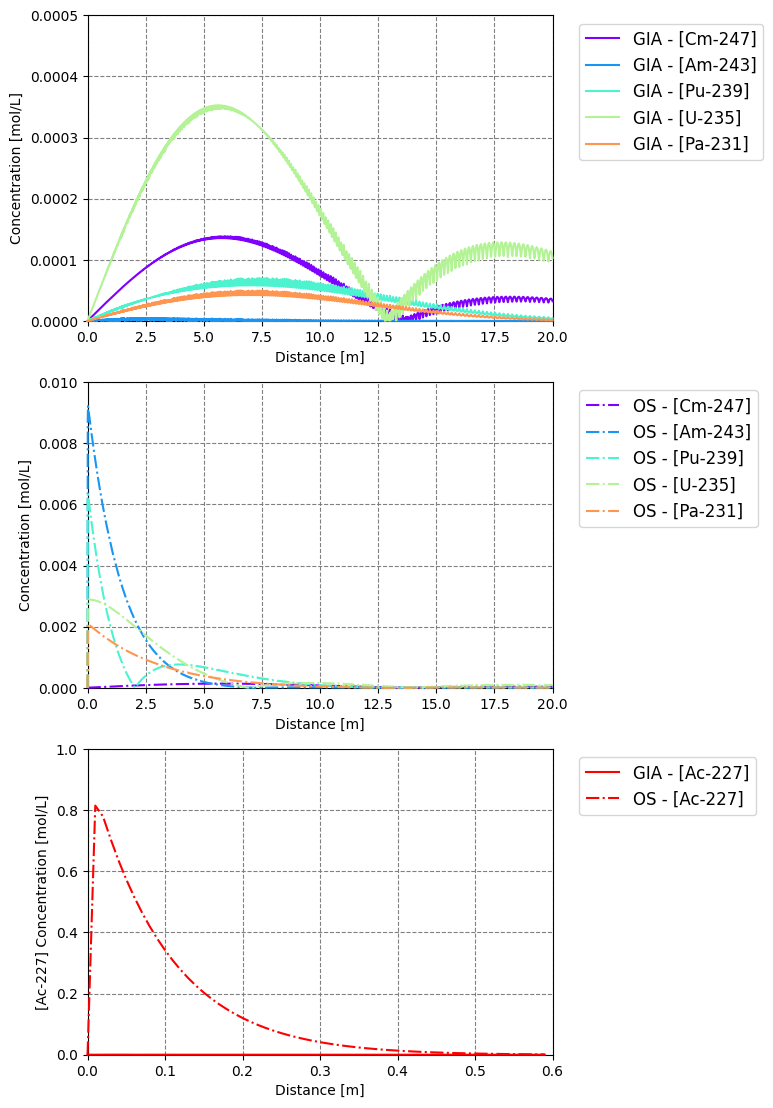

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 13.5))

color_map = cm.rainbow(np.linspace(0, 1, radionuclides.size))

###Plot subfigure 1###
ax1.set(xlim=(0, 20), ylim=(0, 0.0005))
ax1.set(xlabel="Distance [m]", ylabel="Concentration [mol/L]")

# GIA numerical solution
for radionuclide, color in zip(radionuclides[:-1], color_map):
    c_gia = pvdfile_GIA.read_set_data(
        t * 3.1536e7,
        radionuclide,
        data_type="point",
        pointsetarray=[(i, 0, 0) for i in x],
    )
    ax1.plot(
        x,
        abs(c_gia - c[radionuclide]),
        label="GIA - " + radionuclide,
        color=color,
        linestyle="-",
        lw=1.5,
        zorder=10,
        clip_on=False,
    )

ax1.legend(bbox_to_anchor=(1.04, 1), loc="upper left", numpoints=1, fontsize=12, ncol=1)

ax1.xaxis.grid(color="gray", linestyle="dashed")
ax1.yaxis.grid(color="gray", linestyle="dashed")

###Plot subfigure 2###
ax2.set(xlim=(0, 20), ylim=(0, 0.01))
ax2.set(xlabel="Distance [m]", ylabel="Concentration [mol/L]")

# OS numerical solution
for radionuclide, color in zip(radionuclides[:-1], color_map):
    c_os = pvdfile_OS.read_set_data(
        t * 3.1536e7,
        radionuclide,
        data_type="point",
        pointsetarray=[(i, 0, 0) for i in x],
    )
    ax2.plot(
        x,
        abs(c_os - c[radionuclide]),
        label="OS - " + radionuclide,
        color=color,
        linestyle="-.",
        lw=1.5,
        zorder=10,
        clip_on=False,
    )

ax2.legend(bbox_to_anchor=(1.04, 1), loc="upper left", numpoints=1, fontsize=12, ncol=1)

ax2.xaxis.grid(color="gray", linestyle="dashed")
ax2.yaxis.grid(color="gray", linestyle="dashed")

###Plot subfigure 3###
ax3.set(xlim=(0, 0.6), ylim=(0, 1.0))
ax3.set(xlabel="Distance [m]", ylabel="[Ac-227] Concentration [mol/L]")

# GIA numerical solution
Ac_227_gia = pvdfile_GIA.read_set_data(
    t * 3.1536e7, "[Ac-227]", data_type="point", pointsetarray=[(i, 0, 0) for i in x]
)
ax3.plot(
    x[np.where(x < 0.6)],
    abs(Ac_227_gia[np.where(x < 0.6)] - c["[Ac-227]"][np.where(x < 0.6)]),
    label="GIA - [Ac-227]",
    color=color_map[-1],
    linestyle="-",
    lw=1.5,
    zorder=10,
    clip_on=False,
)

# OS numerical solution
Ac_227_os = pvdfile_OS.read_set_data(
    t * 3.1536e7, "[Ac-227]", data_type="point", pointsetarray=[(i, 0, 0) for i in x]
)
ax3.plot(
    x[np.where(x < 0.6)],
    abs(Ac_227_os[np.where(x < 0.6)] - c["[Ac-227]"][np.where(x < 0.6)]),
    label="OS - [Ac-227]",
    color=color_map[-1],
    linestyle="-.",
    lw=1.5,
    zorder=10,
    clip_on=False,
)

ax3.legend(bbox_to_anchor=(1.04, 1), loc="upper left", numpoints=1, fontsize=12, ncol=1)

ax3.xaxis.grid(color="gray", linestyle="dashed")
ax3.yaxis.grid(color="gray", linestyle="dashed")

**The effect of time step size**

As shown in the figure below, the OS solution is rather sensitive to the time stepping scheme. By reducing the time step size from 100 years to 5 years, the solution accuracy near the inlet is greatly improved. Nevertheless, the OS solution accuracy is yet lower than that of the GIA solution despite a larger time step size.

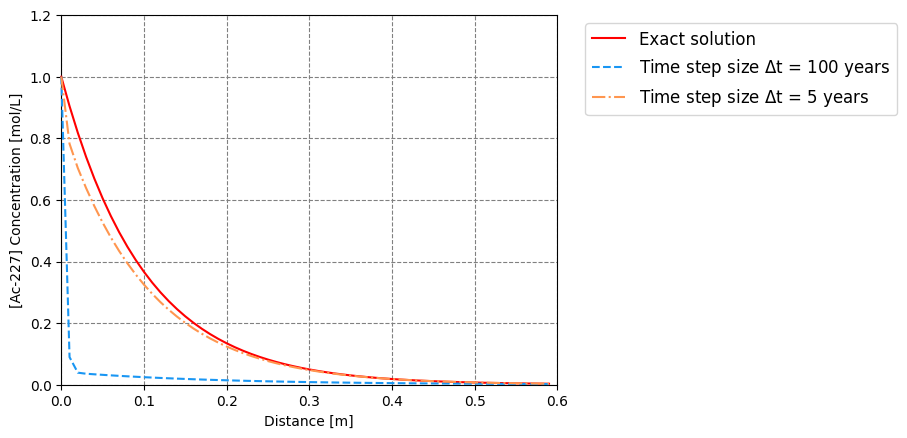

In [8]:
###Read OS solution with a smaller time step size###
pvdfile_OS_small_ts = vtuIO.PVDIO(f"./{prj_name}_OS_5year.pvd", dim=1)

###Plot figure###
fig, ax = plt.subplots()

ax.set(xlim=(0, 0.6), ylim=(0, 1.2))
ax.set(xlabel="Distance [m]", ylabel="[Ac-227] Concentration [mol/L]")

color_map = cm.rainbow(np.linspace(0, 1, radionuclides.size))

# Analytical solution
ax.plot(
    x[np.where(x < 0.6)],
    c["[Ac-227]"][np.where(x < 0.6)],
    linestyle="-",
    lw=1.5,
    label="Exact solution",
    color=color_map[-1],
    zorder=10,
    clip_on=False,
)

# OS solution with a time step size of 100 years
Ac_227_os = pvdfile_OS.read_set_data(
    t * 3.1536e7, "[Ac-227]", data_type="point", pointsetarray=[(i, 0, 0) for i in x]
)
ax.plot(
    x[np.where(x < 0.6)],
    Ac_227_os[np.where(x < 0.6)],
    label=r"Time step size $\Delta$t = 100 years",
    color=color_map[1],
    linestyle="--",
    zorder=10,
    clip_on=False,
)

# OS solution with a time step size of 5 years
Ac_227_os_small_ts = pvdfile_OS_small_ts.read_set_data(
    t * 3.1536e7, "[Ac-227]", data_type="point", pointsetarray=[(i, 0, 0) for i in x]
)
ax.plot(
    x[np.where(x < 0.6)],
    Ac_227_os_small_ts[np.where(x < 0.6)],
    label=r"Time step size $\Delta$t = 5 years",
    color=color_map[-2],
    linestyle="-.",
    zorder=10,
    clip_on=False,
)

ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left", numpoints=1, fontsize=12, ncol=1)

ax.xaxis.grid(color="gray", linestyle="dashed")
ax.yaxis.grid(color="gray", linestyle="dashed")

**Computational performance of two solution strategies**

The runtime of the GIA model is only 22.13 seconds, approximately two orders of magnitude faster than the OS model in this case (see the figure below). Further time profiling analysis for the OS model indicates that Phreeqc consumes over 90 percent of the runtime for solving the local decay-chain problem.

mpirun -np 4 ogs ./GlobalImplicitApproach/MPI/4Processors/1d_decay_chain_GIA.prj -o _out > out.txt
zsh:1: no such file or directory: _out/out.txt
Execution time for the parallelized GIA model with 4 processors is  0.27 s
mpirun -np 8 ogs ./GlobalImplicitApproach/MPI/8Processors/1d_decay_chain_GIA.prj -o _out > out.txt
zsh:1: no such file or directory: _out/out.txt
Execution time for the parallelized GIA model with 8 processors is  0.26 s


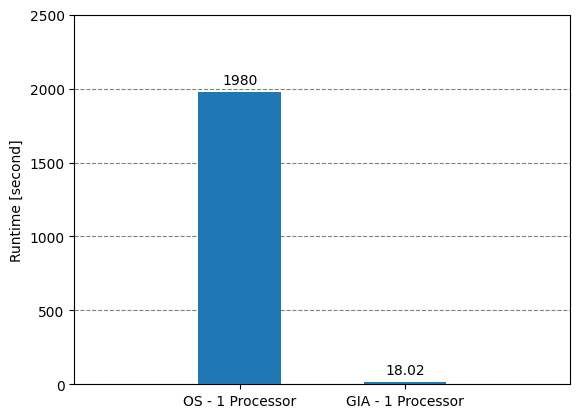

In [10]:
prj_file_GIA_4 = f"./GlobalImplicitApproach/MPI/4Processors/{prj_name}_GIA.prj"
prj_file_GIA_8 = f"./GlobalImplicitApproach/MPI/8Processors/{prj_name}_GIA.prj"

print(f"mpirun -np 4 ogs {prj_file_GIA_4} -o {out_dir} > out.txt")
start_time = time.time()
! mpirun -np 4 ogs {prj_file_GIA_4} -o {out_dir} > {out_dir}/out.txt
end_time = time.time()
runtime_GIA_4 = round(end_time - start_time, 2)
print(
    "Execution time for the parallelized GIA model with 4 processors is ",
    runtime_GIA_4,
    "s",
)

print(f"mpirun -np 8 ogs {prj_file_GIA_8} -o {out_dir} > out.txt")
start_time = time.time()
! mpirun -np 8 ogs {prj_file_GIA_8} -o {out_dir} > {out_dir}/out.txt
end_time = time.time()
runtime_GIA_8 = round(end_time - start_time, 2)
print(
    "Execution time for the parallelized GIA model with 8 processors is ",
    runtime_GIA_8,
    "s",
)

# runtime [second]
runtime = {
    "OS - 1 Processor": 1980,
    "GIA - 1 Processor": runtime_GIA,
    "GIA - 4 Processor": runtime_GIA_4,
    "GIA - 8 Processor": runtime_GIA_8,
}

###Plot figure###
fig, ax = plt.subplots()

ax.set(xlim=(-1, 2), ylim=(0, 2500))

ax.set_ylabel("Runtime [second]")
ax.set_yticks(np.arange(0, 3000, 500))

ax.yaxis.grid(color="gray", linestyle="dashed", zorder=0)

ax.bar(list(runtime.keys())[:2], list(runtime.values())[:2], width=0.5, zorder=3)

for i in range(2):
    ax.annotate(
        list(runtime.values())[i], (i, list(runtime.values())[i] + 50), ha="center"
    )

To summarize, the global implicit approach is clearly superior to the operator splitting approach in terms of solution accuracy and computational performance. Moreover, the global implicit approach even allows for a larger time step size.

**The effect of parallelization on computational performance**

In order to further improve the computational performance of the GIA model, MPI parallelization is employed. As its result, the simulation runtime is drastically reduced down to 4.82 seconds with the number of processors increased to 8. This results in a 4.6X  speed boost.

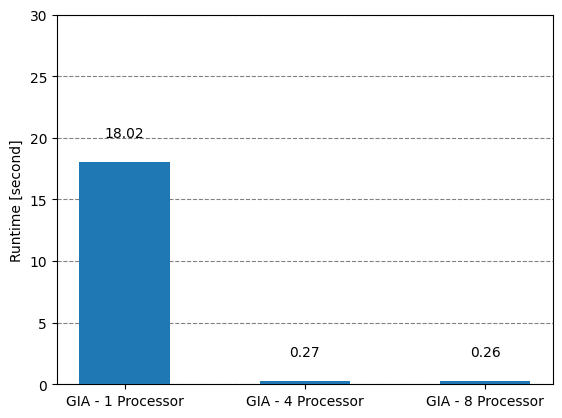

In [12]:
###Plot figure###
fig, ax = plt.subplots()

ax.set(ylim=(0, 30))

ax.set_ylabel("Runtime [second]")
ax.yaxis.grid(color="gray", linestyle="dashed", zorder=0)

ax.bar(list(runtime.keys())[1:], list(runtime.values())[1:], width=0.5, zorder=3)

for i in range(1, 4):
    ax.annotate(
        list(runtime.values())[i], (i - 1, list(runtime.values())[i] + 2), ha="center"
    )

## References

<a href="https://www.grs.de/de/aktuelles/publikationen/grs-289-vsg-radiologische-konsequenzenanalyse-ap-10">(GRS 289)</a> VSG: Radiologische Konsequenzenanalyse (AP 10). J. Larue, B. Baltes, H. Fischer, G. Frieling, I. Kock, M. Navarro, H. Seher.

Sun, Y., Petersen, J. N., & Clement, T. P. (1999). Analytical solutions for multiple species reactive transport in multiple dimensions. Journal of Contaminant Hydrology, 35(4), 429-440.

**Credits:**

Renchao Lu, Christoph Behrens, Dmitri Naumov, Haibing Shao